In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Parámetros de simulación
num_bits = 10000
rango_snr_db = np.arange(0, 11, 2)

In [23]:
# Generación de bits aleatorios
def generar_bits(num_bits):
    return np.random.randint(0, 2, num_bits)

In [24]:
# Conversión de SNR de dB a valor lineal
def snr_db_a_lineal(snr_db):
    return 10 ** (snr_db / 10)

In [25]:
# Ruido AWGN
def agregar_ruido_awgn(senal, snr_db):
    snr_lineal = snr_db_a_lineal(snr_db)
    potencia_senal = np.mean(np.abs(senal) ** 2)
    potencia_ruido = potencia_senal / snr_lineal
    ruido = np.sqrt(potencia_ruido / 2) * (np.random.randn(*senal.shape) + 1j * np.random.randn(*senal.shape))
    return senal + ruido

In [26]:
# Modulación ASK
def modular_ask(bits):
    return np.where(bits == 0, -1, 1)

In [27]:
# Modulación FSK
def modular_fsk(bits, tasa_muestreo=10):
    t = np.arange(0, len(bits) * tasa_muestreo) / tasa_muestreo
    return np.cos(2 * np.pi * bits * t[:len(bits)])

In [28]:
# Modulación BPSK
def modular_bpsk(bits):
    return np.where(bits == 0, -1, 1)

In [29]:
# Modulación 16-QAM
def modular_qam(bits):
    bits = bits[:len(bits) // 4 * 4]  # Asegurar múltiplo de 4 bits
    simbolos = np.reshape(bits, (-1, 4))
    mapeo = {0: -3, 1: -1, 2: 1, 3: 3}
    real = np.array([mapeo[int(''.join(map(str, simbolo[:2])), 2)] for simbolo in simbolos])
    imag = np.array([mapeo[int(''.join(map(str, simbolo[2:])), 2)] for simbolo in simbolos])
    return real + 1j * imag, bits  # Retornar señal QAM y bits ajustados

In [30]:
# Función para demodular y calcular la BER
def calcular_ber(bits, bits_detectados):
    # Ajustar longitud de bits_detectados si es necesario
    longitud_minima = min(len(bits), len(bits_detectados))
    bits = bits[:longitud_minima]
    bits_detectados = bits_detectados[:longitud_minima]
    errores = np.sum(bits != bits_detectados)
    return errores / len(bits)

In [31]:
# Simulación de BER para cada esquema de modulación
def simular_ber(esquema_modulacion):
    bits = generar_bits(num_bits)
    
    if esquema_modulacion == 'ASK':
        senal = modular_ask(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'FSK':
        senal = modular_fsk(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'BPSK':
        senal = modular_bpsk(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'QAM':
        senal, bits = modular_qam(bits)  # Obtener bits redimensionados para QAM
        funcion_demodular = lambda senal: np.concatenate([
            (np.round((senal.real + 2) / 2) > 0).astype(int),
            (np.round((senal.imag + 2) / 2) > 0).astype(int)
        ])
    else:
        raise ValueError("Esquema de modulación no soportado")
    
    ber = []
    for snr_db in rango_snr_db:
        senal_con_ruido = agregar_ruido_awgn(senal, snr_db)
        bits_detectados = funcion_demodular(senal_con_ruido)
        ber.append(calcular_ber(bits, bits_detectados))
    
    return ber

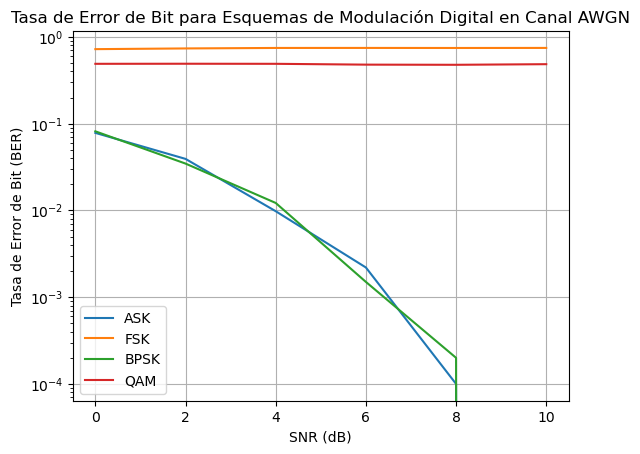

In [ ]:
# Ejecutar simulación para cada esquema de modulación
esquemas_modulacion = ['ASK', 'FSK', 'BPSK', 'QAM']
for esquema_modulacion in esquemas_modulacion:
    ber = simular_ber(esquema_modulacion)
    plt.plot(rango_snr_db, ber, label=esquema_modulacion)
    
# Gráfica de resultados
plt.xlabel("SNR (dB)")
plt.ylabel("Tasa de Error de Bit (BER)")
plt.yscale("log")
plt.title("Tasa de Error de Bit para Esquemas de Modulación Digital en Canal AWGN")
plt.legend()
plt.grid()
plt.show()

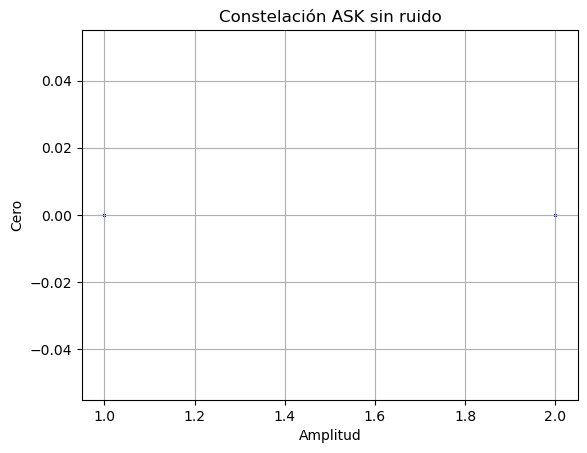

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de simulación
num_bits = 10000

# Generación de bits aleatorios
def generar_bits(num_bits):
    return np.random.randint(0, 2, num_bits)

# Modulación ASK
def modular_ask(bits, amplitud_0=1.0, amplitud_1=2.0):
    return np.where(bits == 0, amplitud_0, amplitud_1)

# Simulación para visualizar la señal sin ruido
def visualizar_senal_sin_ruido():
    bits = generar_bits(num_bits)

    # Modulación
    amplitud_0 = 1.0
    amplitud_1 = 2.0
    senal_tx = modular_ask(bits, amplitud_0, amplitud_1)

    # Graficar constelación
    plt.figure()
    plt.scatter(senal_tx, np.zeros_like(senal_tx), s=1, color='blue')
    plt.title("Constelación ASK sin ruido")
    plt.xlabel("Amplitud")
    plt.ylabel("Cero")
    plt.grid(True)
    plt.show()

    return senal_tx, bits

# Ejecutar la visualización
senal_sin_ruido, bits_sin_ruido = visualizar_senal_sin_ruido()


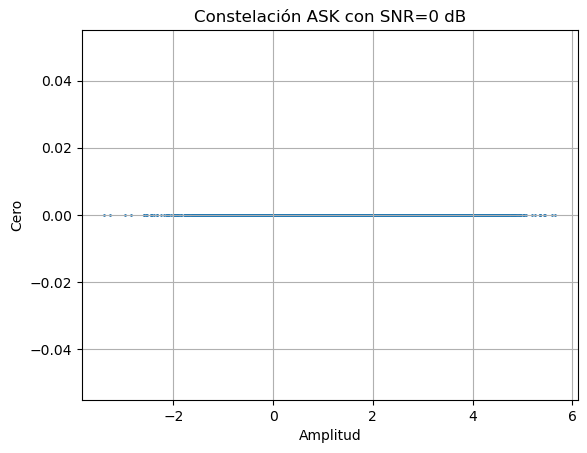

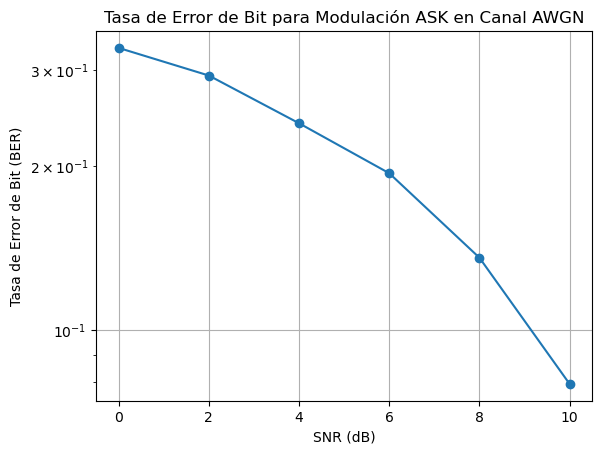

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de simulación
num_bits = 10000
rango_snr_db = np.arange(0, 11, 2)  # SNR en dB

# Generación de bits aleatorios
def generar_bits(num_bits):
    return np.random.randint(0, 2, num_bits)

# Conversión de SNR de dB a valor lineal
def snr_db_a_lineal(snr_db):
    return 10 ** (snr_db / 10)

# Agregar ruido AWGN
def agregar_ruido_awgn(senal, snr_db):
    snr_lineal = snr_db_a_lineal(snr_db)
    potencia_senal = np.mean(np.abs(senal) ** 2)
    potencia_ruido = potencia_senal / snr_lineal
    ruido = np.sqrt(potencia_ruido / 2) * np.random.randn(len(senal))
    return senal + ruido

# Modulación ASK
def modular_ask(bits, amplitud_0=1.0, amplitud_1=2.0):
    return np.where(bits == 0, amplitud_0, amplitud_1)

# Demodulación ASK
def demodular_ask(senal_recibida, amplitud_0=1.0, amplitud_1=2.0):
    umbral = (amplitud_0 + amplitud_1) / 2
    return np.where(senal_recibida >= umbral, 1, 0)

# Calcular BER
def calcular_ber(bits_originales, bits_detectados):
    errores = np.sum(bits_originales != bits_detectados)
    ber = errores / len(bits_originales)
    return ber

# Simulación de BER para modulación ASK
def simular_ber_ask():
    bits = generar_bits(num_bits)

    # Modulación
    amplitud_0 = 1.0
    amplitud_1 = 2.0
    senal_tx = modular_ask(bits, amplitud_0, amplitud_1)

    ber = []
    for snr_db in rango_snr_db:
        # Canal con ruido
        senal_rx = agregar_ruido_awgn(senal_tx, snr_db)

        # Demodulación
        bits_detectados = demodular_ask(senal_rx, amplitud_0, amplitud_1)

        # Calcular BER
        ber.append(calcular_ber(bits, bits_detectados))

        # Graficar constelación para el primer valor de SNR
        if snr_db == rango_snr_db[0]:
            plt.figure()
            plt.scatter(senal_rx, np.zeros_like(senal_rx), s=1)
            plt.title(f"Constelación ASK con SNR={snr_db} dB")
            plt.xlabel("Amplitud")
            plt.ylabel("Cero")
            plt.grid(True)
            plt.show()

    return ber

# Ejecutar la simulación
ber_ask = simular_ber_ask()

# Gráfica de BER
plt.figure()
plt.plot(rango_snr_db, ber_ask, marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Tasa de Error de Bit (BER)")
plt.yscale("log")
plt.title("Tasa de Error de Bit para Modulación ASK en Canal AWGN")
plt.grid(True)
plt.show()


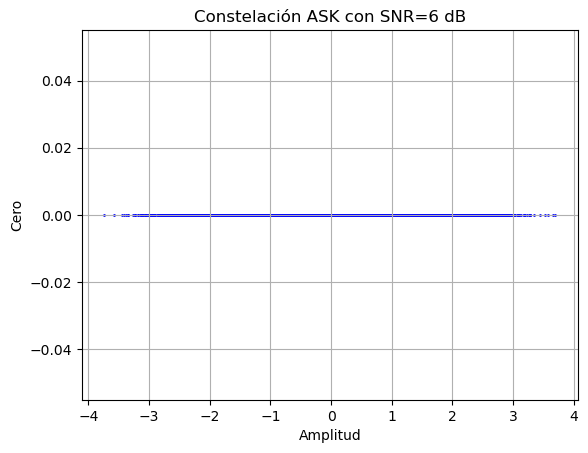

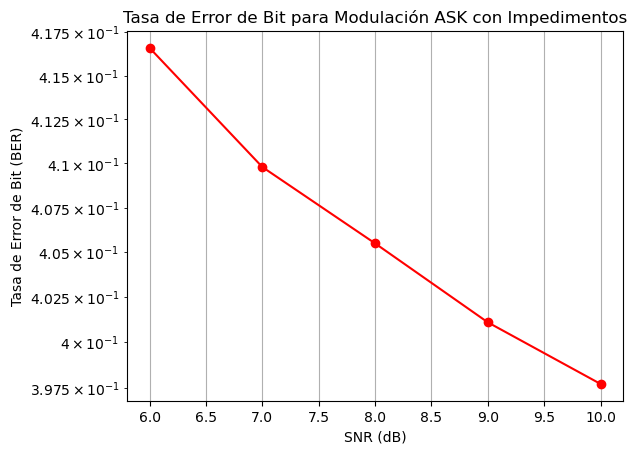

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de simulación
num_bits = 10000
rango_snr_db = np.arange(6, 11, 1)  # SNR en dB

# Generación de bits aleatorios
def generar_bits(num_bits):
    return np.random.randint(0, 2, num_bits)

# Conversión de SNR de dB a valor lineal
def snr_db_a_lineal(snr_db):
    return 10 ** (snr_db / 10)

# Ruido AWGN
def agregar_ruido_awgn(senal, snr_db):
    snr_lineal = snr_db_a_lineal(snr_db)
    potencia_senal = np.mean(np.abs(senal) ** 2)
    potencia_ruido = potencia_senal / snr_lineal
    ruido = np.sqrt(potencia_ruido / 2) * np.random.randn(len(senal))
    return senal + ruido

# Modulación ASK
def modular_ask(bits, amplitud_0=1.0, amplitud_1=2.0):
    return np.where(bits == 0, amplitud_0, amplitud_1)

# Demodulación ASK
def demodular_ask(senal_recibida, amplitud_0=1.0, amplitud_1=2.0):
    umbral = (amplitud_0 + amplitud_1) / 2
    return np.where(senal_recibida >= umbral, 1, 0)

# Canal con impedimentos
def canal_con_impedimentos(senal, snr_db,
                           aplicar_ruido=False, aplicar_desfase=False, desfase=0.0,
                           aplicar_desplazamiento_frecuencia=False, desplazamiento_frecuencia=0.0,
                           tasa_muestreo=1.0):
    # Asegurar que la señal sea de tipo complejo si se aplicará desfasaje o desplazamiento de frecuencia
    if aplicar_desfase or aplicar_desplazamiento_frecuencia:
        senal_modificada = senal.astype(np.complex128).copy()
    else:
        senal_modificada = senal.copy()

    # Aplicar desfasaje
    if aplicar_desfase:
        senal_modificada *= np.exp(1j * desfase)

    # Aplicar desplazamiento de frecuencia
    if aplicar_desplazamiento_frecuencia:
        t = np.arange(len(senal)) / tasa_muestreo
        senal_modificada *= np.exp(1j * 2 * np.pi * desplazamiento_frecuencia * t)

    # Aplicar ruido AWGN
    if aplicar_ruido:
        senal_modificada = agregar_ruido_awgn(senal_modificada, snr_db)

    return senal_modificada

# Simulación de BER para modulación ASK con impedimentos
def simular_ask_con_impedimentos(aplicar_ruido=False, aplicar_desfase=False, desfase=0.0,
                                 aplicar_desplazamiento_frecuencia=False, desplazamiento_frecuencia=0.0):
    bits = generar_bits(num_bits)

    # Modulación
    amplitud_0 = 1.0
    amplitud_1 = 2.0
    senal_tx = modular_ask(bits, amplitud_0, amplitud_1)

    ber = []
    for snr_db in rango_snr_db:
        # Canal con impedimentos
        senal_rx = canal_con_impedimentos(
            senal_tx, snr_db,
            aplicar_ruido=aplicar_ruido,
            aplicar_desfase=aplicar_desfase, desfase=desfase,
            aplicar_desplazamiento_frecuencia=aplicar_desplazamiento_frecuencia, desplazamiento_frecuencia=desplazamiento_frecuencia
        )

        # Para constelación, tomar la parte real
        senal_rx_real = np.real(senal_rx)

        # Demodulación
        bits_detectados = demodular_ask(senal_rx_real, amplitud_0, amplitud_1)

        # Calcular BER
        ber.append(calcular_ber(bits, bits_detectados))

        # Graficar constelación para el primer valor de SNR
        if snr_db == rango_snr_db[0]:
            plt.figure()
            plt.scatter(senal_rx_real, np.zeros_like(senal_rx_real), s=1, color='blue')
            plt.title(f"Constelación ASK con SNR={snr_db} dB")
            plt.xlabel("Amplitud")
            plt.ylabel("Cero")
            plt.grid(True)
            plt.show()

    return ber

# Calcular BER
def calcular_ber(bits_originales, bits_detectados):
    errores = np.sum(bits_originales != bits_detectados)
    ber = errores / len(bits_originales)
    return ber








# Parámetros de impedimentos
aplicar_ruido = True            # Activa o desactiva el ruido AWGN
aplicar_desfase = True          # Activa o desactiva el desfasaje
desfase = np.pi / 8             # Desfasaje en radianes

aplicar_desplazamiento_frecuencia = True    # Activa o desactiva el desplazamiento de frecuencia
desplazamiento_frecuencia = 0.01            # Desplazamiento de frecuencia en Hz
tasa_muestreo = 1.0                         # Tasa de muestreo para el desplazamiento de frecuencia








# Ejecutar la simulación con los impedimentos seleccionados
ber_ask = simular_ask_con_impedimentos(
    aplicar_ruido=aplicar_ruido,
    aplicar_desfase=aplicar_desfase, desfase=desfase,
    aplicar_desplazamiento_frecuencia=aplicar_desplazamiento_frecuencia, desplazamiento_frecuencia=desplazamiento_frecuencia
)

# Gráfica de BER
plt.figure()
plt.plot(rango_snr_db, ber_ask, marker='o', color='red')
plt.xlabel("SNR (dB)")
plt.ylabel("Tasa de Error de Bit (BER)")
plt.yscale("log")
plt.title("Tasa de Error de Bit para Modulación ASK con Impedimentos")
plt.grid(True)
plt.show()
